# Supervised ANN Model Using Building Facade Features

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('EUI_and_Weather_cleaned.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251782 entries, 0 to 251781
Data columns (total 31 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        251782 non-null  int64  
 1   BLDG_UID          251781 non-null  object 
 2   Building          251781 non-null  object 
 3   Date              251782 non-null  object 
 4   HDD_daily         251782 non-null  float64
 5   CDD_daily         251782 non-null  float64
 6   GHI_sum           251782 non-null  int64  
 7   Avg_Temp_Daily    251782 non-null  float64
 8   Humidity_avg      251782 non-null  float64
 9   Elec_Power        199777 non-null  float64
 10  Thrm_Energy       114030 non-null  float64
 11  Thrm_Power        105562 non-null  float64
 12  Wtr_Cns           174421 non-null  float64
 13  Elec_EUI          193650 non-null  float64
 14  Thrm_EUI          113594 non-null  float64
 15  Wtr_WUI           186816 non-null  float64
 16  Total_EUI_excwtr  11

In [4]:
data['Occu_Date'] = data['Occu_Date']//10000
data['Occu_Date'] = data['Occu_Date'] >= 1970

In [5]:
bldg_yr = data[['Occu_Date', 'Building', 'Total_EUI_excwtr']]
bldg_yr.loc[bldg_yr['Occu_Date'] == True, 'Occu_Date'] = "After 1970"
bldg_yr.loc[bldg_yr['Occu_Date'] == False, 'Occu_Date'] = "Before 1970"
bldg_yr.head()

,Occu_Date,Building,Total_EUI_excwtr
0,After 1970,AERL,NaN
1,After 1970,AERL,NaN
2,After 1970,AERL,NaN
3,After 1970,AERL,NaN
4,After 1970,AERL,NaN


In [6]:
bldg_yr['Total_EUI_excwtr'].describe()

count    111331.000000
mean          0.734311
std           0.488344
min           0.000220
25%           0.377033
50%           0.604687
75%           0.971764
max           3.146596
Name: Total_EUI_excwtr, dtype: float64

# Construction Type

In [7]:
bldg_list = list(data['Building'].unique())

constr_type = data[['Building', 'Constr_Type']]
constr_type= constr_type.drop_duplicates(subset=['Building']).dropna()
constr_type.head()

,Building,Constr_Type
0,AERL,Concrete
3649,Alumni Centre,Concrete
7298,AMS Nest,Concrete
10947,Aquatic Centre,Concrete
14596,Art Students Centre,Concrete


## Label Encoding

In [8]:
# Manual label encoding for increasing thermal resistance of material
ordinal_sequence = ['Wood', 'Concrete', 'Steel', 'OtherMixed']

# Create a custom mapping function
def custom_encode(category):
    return ordinal_sequence.index(category)

# Apply the custom mapping function to the DataFrame
constr_type['Encoded_Constr_Type'] = constr_type['Constr_Type'].apply(custom_encode)

constr_type.head()

,Building,Constr_Type,Encoded_Constr_Type
0,AERL,Concrete,1
3649,Alumni Centre,Concrete,1
7298,AMS Nest,Concrete,1
10947,Aquatic Centre,Concrete,1
14596,Art Students Centre,Concrete,1


In [9]:
EUI_params = ['Elec_EUI', 'Thrm_EUI', 'Wtr_WUI']
bldg_feat = ['Occu_Date', 'Constr_Type', 'MAX_Floors', 'FSP_Classroom', 'FSP_Lab', 'FSP_Library', 'FSP_Office',
            'BLDG_Height', 'GFA', 'GBA']
bldg_feat_df = data[EUI_params+bldg_feat]
bldg_feat_df

,Elec_EUI,Thrm_EUI,Wtr_WUI,Occu_Date,Constr_Type,MAX_Floors,FSP_Classroom,FSP_Lab,FSP_Library,FSP_Office,BLDG_Height,GFA,GBA
0,0.229089,NaN,0.001099,True,Concrete,6.0,0.06,0.05,0.0,0.46,19.33000,5368.0,5731.0
1,0.261573,NaN,0.001379,True,Concrete,6.0,0.06,0.05,0.0,0.46,19.33000,5368.0,5731.0
2,0.313268,NaN,0.001714,True,Concrete,6.0,0.06,0.05,0.0,0.46,19.33000,5368.0,5731.0
3,0.308332,NaN,0.001900,True,Concrete,6.0,0.06,0.05,0.0,0.46,19.33000,5368.0,5731.0
4,0.293685,NaN,0.001975,True,Concrete,6.0,0.06,0.05,0.0,0.46,19.33000,5368.0,5731.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
251777,0.486820,0.214607,0.001042,False,Concrete,4.0,0.08,0.01,0.0,0.15,21.11571,7777.0,7695.0
251778,0.430018,0.359875,0.001042,False,Concrete,4.0,0.08,0.01,0.0,0.15,21.11571,7777.0,7695.0
251779,0.378042,0.252057,0.001029,False,Concrete,4.0,0.08,0.01,0.0,0.15,21.11571,7777.0,7695.0
251780,0.389197,0.274656,0.001042,False,Concrete,4.0,0.08,0.01,0.0,0.15,21.11571,7777.0,7695.0


In [10]:
# Manual label encoding for increasing thermal resistance of material
ordinal_sequence = ['Wood', 'Concrete', 'Steel', 'OtherMixed']

# Create a custom mapping function
def custom_encode(category):
    return ordinal_sequence.index(category)

# Apply the custom mapping function to the DataFrame
bldg_feat_df = bldg_feat_df.dropna(subset=['Constr_Type'])
bldg_feat_df['Constr_Type'] = bldg_feat_df['Constr_Type'].apply(custom_encode)

bldg_feat_df.head(20)

,Elec_EUI,Thrm_EUI,Wtr_WUI,Occu_Date,Constr_Type,MAX_Floors,FSP_Classroom,FSP_Lab,FSP_Library,FSP_Office,BLDG_Height,GFA,GBA
0,0.229089,NaN,0.001099,True,1,6.0,0.06,0.05,0.0,0.46,19.33,5368.0,5731.0
1,0.261573,NaN,0.001379,True,1,6.0,0.06,0.05,0.0,0.46,19.33,5368.0,5731.0
2,0.313268,NaN,0.001714,True,1,6.0,0.06,0.05,0.0,0.46,19.33,5368.0,5731.0
3,0.308332,NaN,0.001900,True,1,6.0,0.06,0.05,0.0,0.46,19.33,5368.0,5731.0
4,0.293685,NaN,0.001975,True,1,6.0,0.06,0.05,0.0,0.46,19.33,5368.0,5731.0
5,0.290751,NaN,0.002086,True,1,6.0,0.06,0.05,0.0,0.46,19.33,5368.0,5731.0
6,0.209668,NaN,0.001174,True,1,6.0,0.06,0.05,0.0,0.46,19.33,5368.0,5731.0
7,0.213091,NaN,0.001136,True,1,6.0,0.06,0.05,0.0,0.46,19.33,5368.0,5731.0
8,0.298761,NaN,0.002180,True,1,6.0,0.06,0.05,0.0,0.46,19.33,5368.0,5731.0
9,0.300624,NaN,NaN,True,1,6.0,0.06,0.05,0.0,0.46,19.33,5368.0,5731.0


In [11]:
#bldg_feat_df.to_csv('EUI_Bldg_Features.csv')

# Model Development

In [12]:
ann_data = data[["Total_EUI_excwtr", "DayOfYear"]+EUI_params+bldg_feat]

ann_data = ann_data.dropna(subset=["Constr_Type"])
ann_data['Constr_Type'] = ann_data['Constr_Type'].apply(custom_encode)
ann_data = ann_data.dropna()
ann_data = ann_data.drop(["Elec_EUI", "Thrm_EUI", "Wtr_WUI", "DayOfYear"], axis=1)
ann_data.head()

,Total_EUI_excwtr,Occu_Date,Constr_Type,MAX_Floors,FSP_Classroom,FSP_Lab,FSP_Library,FSP_Office,BLDG_Height,GFA,GBA
1652,0.296107,True,1,6.0,0.06,0.05,0.0,0.46,19.33,5368.0,5731.0
1653,0.350270,True,1,6.0,0.06,0.05,0.0,0.46,19.33,5368.0,5731.0
1654,0.364655,True,1,6.0,0.06,0.05,0.0,0.46,19.33,5368.0,5731.0
1655,0.340630,True,1,6.0,0.06,0.05,0.0,0.46,19.33,5368.0,5731.0
1656,0.259640,True,1,6.0,0.06,0.05,0.0,0.46,19.33,5368.0,5731.0


In [13]:
x = ann_data.iloc[:, 1:]
y = ann_data.iloc[:, 0]

## Feature Scaling

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=0)

In [15]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Build the ANN

The weights of each neuron is initialized with certain values, and these values are updated during the training process through backpropagation.

In [16]:
import keras
from keras.models import Sequential
from keras.layers import Dense

import numpy as np
import tensorflow as tf

total_vars = len(x.columns)

# Create a Sequential model
model = Sequential()

# Add an input layer with 14 input features
model.add(Dense(units=15, activation='relu', input_dim=total_vars))

# Add the first hidden layer with 10 neurons and ReLU activation
model.add(Dense(units=15, activation='relu'))

# Add the second hidden layer with 8 neurons and ReLU activation
model.add(Dense(units=1, activation='relu'))

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics='mae')

# Print a summary of the model's architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                165       
                                                                 
 dense_1 (Dense)             (None, 15)                240       
                                                                 
 dense_2 (Dense)             (None, 1)                 16        
                                                                 
Total params: 421 (1.64 KB)
Trainable params: 421 (1.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
r = model.fit(
    X_train,
    y_train,
    epochs = 50,
    validation_data = (X_test, y_test)
)

Epoch 1/50
2272/2272 [==============================] - 5s 2ms/step - loss: 0.1138 - mae: 0.2579 - val_loss: 0.0857 - val_mae: 0.2291
Epoch 2/50
2272/2272 [==============================] - 4s 2ms/step - loss: 0.0781 - mae: 0.2194 - val_loss: 0.0735 - val_mae: 0.2122
Epoch 3/50
2272/2272 [==============================] - 5s 2ms/step - loss: 0.0745 - mae: 0.2141 - val_loss: 0.0729 - val_mae: 0.2129
Epoch 4/50
2272/2272 [==============================] - 4s 2ms/step - loss: 0.0738 - mae: 0.2129 - val_loss: 0.0719 - val_mae: 0.2113
Epoch 5/50
2272/2272 [==============================] - 5s 2ms/step - loss: 0.0734 - mae: 0.2121 - val_loss: 0.0742 - val_mae: 0.2146
Epoch 6/50
2272/2272 [==============================] - 5s 2ms/step - loss: 0.0733 - mae: 0.2122 - val_loss: 0.0715 - val_mae: 0.2095
Epoch 7/50
2272/2272 [==============================] - 5s 2ms/step - loss: 0.0732 - mae: 0.2120 - val_loss: 0.0725 - val_mae: 0.2107
Epoch 8/50
2272/2272 [==============================] - 5s 2ms

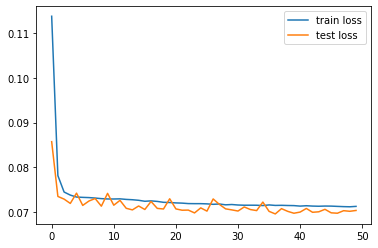

In [18]:
# y_pred = (y_pred > 0.5)

# Plot loss function
plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'test loss')
plt.legend()

In [19]:
# Fit predictions
Y_pred = model.predict(X_test).flatten()

len(Y_pred)

568/568 [==============================] - 1s 2ms/step


18172

## Feature Weight Analysis

In [21]:
# All weights
for layer in model.layers: print(layer.get_config(), layer.get_weights())
    
first_layer_weights = model.layers[0].get_weights()[0]
first_layer_biases  = model.layers[0].get_weights()[1]
second_layer_weights = model.layers[1].get_weights()[0]
second_layer_biases  = model.layers[1].get_weights()[1]

{'name': 'dense', 'trainable': True, 'dtype': 'float32', 'batch_input_shape': (None, 10), 'units': 15, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None} [array([[-0.16268997, -0.1315596 ,  0.4885258 ,  0.71811557, -0.31000066,
        -0.09178004, -0.09076521, -0.193299  ,  0.05795852, -0.08359643,
         0.419342  ,  0.31936938, -0.4635886 ,  0.21989168, -0.3215691 ],
       [-0.02910876,  0.22110444, -0.3406425 ,  0.18877625,  0.5219787 ,
         0.07200624,  0.08420102, -0.0820745 , -0.16208133,  0.13670057,
         0.53081614, -0.4870577 , -0.35627234,  0.15965699,  0.29236117],
       [-0.41475534,  0.39

In [22]:
print(len(X_test))
print(len(y))
print(len(y_test))
print(len(Y_pred))

18172
90860
18172
18172


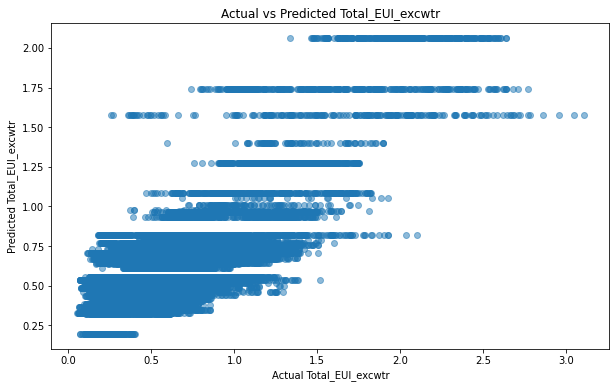

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming 'model' is your trained ANN model
# X_test is your feature matrix for testing
# y_test_actual is the actual 'Total_EUI_excwtr' values for testing

# Predict the values using your model
# y_pred = model.predict(X_test)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, Y_pred, alpha=0.5)
plt.title('Actual vs Predicted Total_EUI_excwtr')
plt.xlabel('Actual Total_EUI_excwtr')
plt.ylabel('Predicted Total_EUI_excwtr')
plt.show()

## Model Evaluation

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(y_test, Y_pred)
print(f"Mean Squared Error: {mse}")

mae = mean_absolute_error(y_test, Y_pred)
print(f"Mean Absolute Error: {mae}")

r2 = r2_score(y_test, Y_pred)
print(f"R-squared: {r2}")


Mean Squared Error: 0.07035265009435808
Mean Absolute Error: 0.2080698180196655
R-squared: 0.6246687488590184
